## Setup

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F

from src.data import DataLoaderScratch
from src.trainer import TrainerScratch
from src.optimizers import SGDScratch
from src.losses import CrossEntropyScratch
from src.metrics import AccuracyScratch
from src.functions import conv2d, maxpool2d

## Data Loading and Preprocessing

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
mnist_trainset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
mnist_testset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

# Transform the training data
X_train = mnist_trainset.data[:1000, :, :].float() / 255.0
# Add single dimension for the input channel
X_train = X_train.unsqueeze(1)
y_train = mnist_trainset.targets[:1000]

# Transform the test data
X_val = mnist_testset.data[:100, :, :].float() / 255.0
# Add single dimension for the input channel
X_val = X_val.unsqueeze(1)
y_val = mnist_testset.targets[:100]

train_dataloader = DataLoaderScratch(X_train, y_train, batch_size=256, shuffle=True)
val_dataloader = DataLoaderScratch(X_val, y_val, batch_size=256, shuffle=False)

### Single Batch Iteration

In [3]:
def relu(x):
    out = torch.maximum(x, torch.zeros(1))
    return out

def softmax(X):
    X_exp = torch.exp(X)
    X_softmax = X_exp / X_exp.sum(axis=1, keepdims=True)
    return X_softmax

def log_loss(y_pred, y):
    y_one_hot = nn.functional.one_hot(y)
    loss = -(y_one_hot * torch.log(y_pred)).sum(axis=1).mean()
    return loss

def calculate_same_padding(input_size, kernel_size, stride):
    if input_size % stride == 0:
        pad_total = max(kernel_size - stride, 0)
    else:
        pad_total = max(kernel_size - (input_size % stride), 0)
    padding = pad_total // 2
    return padding

In [4]:
in_channels = 1
filter_size = 3 # Filter size for all layers

num_classes = 10

# CONV + POOL Layer 1 (sees 1x28x28 and outputs 16x14x14)
W1 = nn.Parameter(torch.randn(16, in_channels, filter_size, filter_size) * 0.1)
b1 =  nn.Parameter(torch.zeros(size=(1, 16, 1, 1)))

# CONV + POOL Layer 2 (sees 16x14x14 and outputs 32x7x7)
W2 = nn.Parameter(torch.randn(32, 16, filter_size, filter_size) * 0.1)
b2 = nn.Parameter(torch.zeros(size=(1, 32, 1, 1)))

# FC Layer (sees 32x7x7 and outputs 32*7*7x10)
W3 = nn.Parameter(torch.randn(32 * 7 * 7, num_classes) * 0.1)
b3 = nn.Parameter(torch.zeros(num_classes))

parameters = [W1, b1, W2, b2, W3, b3]
optimizer = SGDScratch(parameters, lr=0.1)

In [5]:
num_epochs = 3
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_dataloader:
        inputs, targets = batch

        batch_size, in_channels, input_height, input_width = inputs.shape
    
        # Zero gradients
        optimizer.zero_grad()
    
        # CONV + POOL Layer 1 (sees 1x28x28 and outputs 16x14x14)
        padding = calculate_same_padding(input_size=28, kernel_size=3, stride=1)
        Z1 = conv2d(inputs, W1, padding=padding) + b1
        A1 = relu(Z1)
        P1 = maxpool2d(A1, kernel_size=2, stride=2)
    
        # CONV + POOL Layer 2 (sees 16x14x14 and outputs 32x7x7)
        padding = calculate_same_padding(input_size=14, kernel_size=3, stride=1)
        Z2 = conv2d(P1, W2, padding=padding) + b2
        A2 = relu(Z2)
        P2 = maxpool2d(A2, kernel_size=2, stride=2)
    
        # FC Layer (sees 32x7x7 and outputs 32*7*7x10)
        P2_flat = P2.flatten(start_dim=1)
        Z3 = P2_flat @ W3 + b3
        y_pred = softmax(Z3)
    
        # Calculate Loss
        loss = log_loss(y_pred, targets)
    
        # Compute gradients
        loss.backward()
    
        # Update parameters
        optimizer.step()
        total_loss += loss.item()

    print(total_loss / len(train_dataloader))

2.285222887992859
2.1936349272727966
2.0781480073928833


### Define Training Loop and Model

In [6]:
class CNNScratch(nn.Module):
    def __init__(self, in_channels, input_height, input_width, filter_size, num_classes):
        super().__init__()
        self.input_height = input_height
        self.filter_size = filter_size
        out_channels1 = 16 # Number of filters in the first conv layer
        self.W1 = nn.Parameter(torch.randn(out_channels1, in_channels, filter_size, filter_size) * 0.1)
        self.b1 =  nn.Parameter(torch.zeros(size=(1, out_channels1, 1, 1)))
        out_channels2 = 32 # Number of filters in the second conv layer
        self.W2 = nn.Parameter(torch.randn(out_channels2, out_channels1, filter_size, filter_size) * 0.1)
        self.b2 = nn.Parameter(torch.zeros(size=(1, out_channels2, 1, 1)))
        self.W3 = nn.Parameter(torch.randn(out_channels2 * int(input_height/4 * input_width/4), num_classes) * 0.1)
        self.b3 = nn.Parameter(torch.zeros(num_classes))

    def forward(self, X):
        # Forward pass
        pool_size = 2

        # CONV + POOL Layer 1 (sees 1x28x28 and outputs 16x14x14)
        padding = calculate_same_padding(input_size=28, kernel_size=3, stride=1)
        Z1 = conv2d(X, self.W1, padding=padding) + self.b1
        A1 = relu(Z1)
        P1 = maxpool2d(A1, kernel_size=2, stride=2)
    
        # CONV + POOL Layer 2 (sees 16x14x14 and outputs 32x7x7)
        padding = calculate_same_padding(input_size=14, kernel_size=3, stride=1)
        Z2 = conv2d(P1, self.W2, padding=padding) + self.b2
        A2 = relu(Z2)
        P2 = maxpool2d(A2, kernel_size=2, stride=2)
    
        # FC Layer (sees 32x7x7 and outputs 32*7*7x10)
        P2_flat = P2.flatten(start_dim=1)
        Z3 = P2_flat @ self.W3 + self.b3
        y_pred = softmax(Z3)
        return y_pred

    def parameters(self):
        return [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]

In [7]:
input_height, input_width = 28, 28
in_channels = 1
filter_size = 3 # Filter size for all layers
num_classes = y_train.unique().shape[0]

num_epochs = 20
learning_rate = 0.2

model = CNNScratch(in_channels, input_height, input_width, filter_size, num_classes)
optimizer = SGDScratch(model.parameters(), lr=learning_rate)
criterion = CrossEntropyScratch(num_classes=num_classes)
metrics = {'accuracy': AccuracyScratch()}
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion, custom_metrics=metrics)
trainer.fit(num_epochs=num_epochs)

Epoch 1/20, Training Loss: 2.1438, Validation Loss: 1.8239
Validation accuracy: 0.3500


## Concise Implementation of CNN

Epoch 1/20, Training Loss: 2.2703, Validation Loss: 2.2044
Validation accuracy: 0.4300
Epoch 2/20, Training Loss: 2.1353, Validation Loss: 1.9766
Validation accuracy: 0.4700
Epoch 3/20, Training Loss: 1.7704, Validation Loss: 1.7825
Validation accuracy: 0.4900
Epoch 4/20, Training Loss: 1.7789, Validation Loss: 1.1371
Validation accuracy: 0.7000
Epoch 5/20, Training Loss: 1.4560, Validation Loss: 1.7948
Validation accuracy: 0.5600
Epoch 6/20, Training Loss: 1.4385, Validation Loss: 0.8319
Validation accuracy: 0.7600
Epoch 7/20, Training Loss: 0.9231, Validation Loss: 1.2900
Validation accuracy: 0.6400
Epoch 8/20, Training Loss: 0.9161, Validation Loss: 0.6324
Validation accuracy: 0.8200
Epoch 9/20, Training Loss: 0.5597, Validation Loss: 0.5607
Validation accuracy: 0.8100
Epoch 10/20, Training Loss: 0.4115, Validation Loss: 0.4607
Validation accuracy: 0.8400
Epoch 11/20, Training Loss: 0.4604, Validation Loss: 0.5141
Validation accuracy: 0.8500
Epoch 12/20, Training Loss: 0.3650, Valid

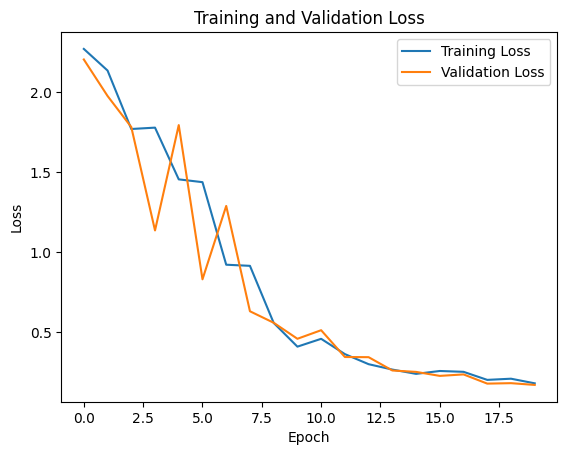

In [ ]:
# Assuming X and y are your feature and target tensors
# Split Data into Train and Test Sets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Define DataLoader
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        # CONV + POOL Layer 1 (sees 1x28x28 and outputs 16x14x14)
        padding = calculate_same_padding(input_size=28, kernel_size=3, stride=1)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=padding)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # CONV + POOL Layer 2 (sees 16x14x14 and outputs 32x7x7)
        padding = calculate_same_padding(input_size=14, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=padding)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # FC Layer (sees 32x7x7 and outputs 32*7*7x10)
        self.fc1 = nn.Linear(32 * 7 * 7, num_classes)


    def forward(self, x):
        # CONV + POOL Layer 1 (sees 1x28x28 and outputs 16x14x14)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        # CONV + POOL Layer 2 (sees 16x14x14 and outputs 32x7x7)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # FC Layer (sees 32x7x7 and outputs 32*7*7x10)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)

        return x

num_classes = y_train.unique().shape[0]
model = CNN(num_classes)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.2)
metrics = {'accuracy':AccuracyScratch()}
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion, custom_metrics=metrics)
trainer.fit(num_epochs=20)

In [ ]:
# Assuming the AccuracyScratch class is defined as per your snippet
# Ensure your model, train_loader, and val_loader are defined

# Initialize accuracy trackers
train_accuracy = AccuracyScratch()
val_accuracy = AccuracyScratch()

# Set model to evaluation mode
model.eval()

# No gradient calculation needed for evaluation
with torch.no_grad():
    # Calculate training accuracy
    for inputs, labels in train_dataloader:
        outputs = model(inputs)
        train_accuracy.update(outputs, labels)
    
    train_acc = train_accuracy.compute()
    train_accuracy.reset()  # Reset for future use if needed

    # Calculate validation accuracy
    for inputs, labels in val_dataloader:
        outputs = model(inputs)
        val_accuracy.update(outputs, labels)
    
    val_acc = val_accuracy.compute()
    val_accuracy.reset()  # Reset for future use if needed

print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Validation Accuracy: {val_acc*100:.2f}%")


Training Accuracy: 95.40%
Validation Accuracy: 95.00%
